In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Directory containing the .nc files
data_dir = '/global/scratch/users/liuwenjin021011/data/CHIRPS/'
nc_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.nc'):
            nc_files.append(os.path.join(root, file))
print(len(nc_files))

3


In [2]:
dataset_2017 = Dataset('/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2017.days_p05.nc', 'r')
dataset_2018 = Dataset('/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2018.days_p05.nc', 'r')
dataset_2019 = Dataset('/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2019.days_p05.nc', 'r')

dataset = dataset_2017
dataset.variables.keys()

dict_keys(['latitude', 'longitude', 'precip', 'time'])

In [6]:
LAI

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

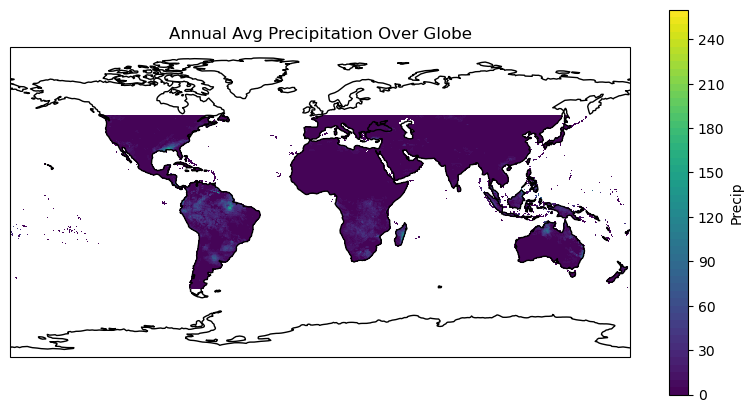

In [7]:
# Visualize the first dataset to get the idea of the locations being included in NOAA_LAI data


latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
LAI = dataset.variables['precip'][0, :, :]  # Assuming time is the first dimension

def Visualize_on_Geo_Map(latitude, longitude, data):
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()

    plt.contourf(longitude, latitude, data, 60, transform=ccrs.PlateCarree())
    # plt.contourf(longitude, latitude, data, 60, transform=ccrs.PlateCarree(), vmin=0, vmax=90)
    
    plt.colorbar(label='Precip')
    plt.title('Annual Avg Precipitation Over Globe')
    plt.show()
    
Visualize_on_Geo_Map(latitude, longitude, LAI)

In [ ]:
# filter the Area of Interest in China only, and plot the filter map to double check

Precip = dataset.variables['precip'][0, :, :]
Precip_flat = Precip.ravel()

def filter_for_china_shapefile(nc_file_path, shapefile_path, Precip_flat):
    # Load NetCDF file
    dataset = Dataset(nc_file_path, 'r')
    latitudes = dataset.variables['latitude'][:]
    longitudes = dataset.variables['longitude'][:]
      # Taking the first time slice
    dataset.close()

    # Prepare coordinates for each point and flatten LAI data
    lon, lat = np.meshgrid(longitudes, latitudes)

    df = pd.DataFrame({
        'Latitude': lat.ravel(),
        'Longitude': lon.ravel(),
        'Precip': Precip_flat
    })
    df = df.dropna()

    print("DataFrame size after dropping NaNs:", df.shape)

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gdf.set_crs(epsg=4326, inplace=True)

    print("Checking CRS of shapefile...")
    china_shape = gpd.read_file(shapefile_path)
    print("Shapefile CRS:", china_shape.crs)

    # Perform spatial join
    filtered_gdf = gpd.sjoin(gdf, china_shape, how='inner', op='intersects')

    print("Filtered GeoDataFrame size:", filtered_gdf.shape)
    return filtered_gdf[['Latitude', 'Longitude', 'Precip']]

nc_file_path = nc_files[0]
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'
filtered_data = filter_for_china_shapefile(nc_file_path, shapefile_path, Precip_flat)

DataFrame size after dropping NaNs: (3858552, 3)
Checking CRS of shapefile...
Shapefile CRS: None


/global/home/users/liuwenjin021011/.conda/envs/NOx_selina/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_32702/1845631687.py:35: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  filtered_gdf = gpd.sjoin(gdf, china_shape, how='inner', op='intersects')


In [ ]:
filtered_data

In [ ]:
def plot_lai_on_map(filtered_gdf):

    # Create a figure and axis with a map projection
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotting the shape of the world for context
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='white', edgecolor='black')

    # Plotting the LAI data with smaller dots
    # Adjust the markersize as needed
    filtered_gdf.plot(column='LAI', ax=ax, legend=True, cmap='viridis', markersize=0.1)

    plt.title('Leaf Area Index (LAI) over China')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()


In [ ]:
nc_files

In [ ]:
all_filtered_dfs = []
for i in np.arange(239, 365):
    Precip = dataset_2017.variables['precip'][i, :, :]
    Precip_flat = Precip.ravel()
    
    nc_file_path = '/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2017.days_p05.nc'
    shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'
    filtered_df = filter_for_china_shapefile(nc_file_path, shapefile_path, Precip_flat)
    filtered_df['Day'] = [i] * filtered_df.shape[0]
    all_filtered_dfs.append(filtered_df)



In [ ]:
total_df_2017.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2017_Last_Half.csv', index = False, header = True)

In [22]:
all_filtered_dfs = []
for i in np.arange(365):
    Precip = dataset_2018.variables['precip'][i, :, :]
    Precip_flat = Precip.ravel()
    
    nc_file_path = '/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2018.days_p05.nc'
    shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'
    filtered_df = filter_for_china_shapefile(nc_file_path, shapefile_path, Precip_flat)
    filtered_df['Day'] = [i] * filtered_df.shape[0]
    all_filtered_dfs.append(filtered_df)

total_df_2018 = pd.concat(all_filtered_dfs, ignore_index=True)

    
total_df_2018.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2018.csv', index = False, header = True)

,Latitude,Longitude,Precip,Day
0,18.174995,109.575012,0.000000,0
1,18.224998,109.524994,0.000000,0
2,18.224998,109.575012,0.000000,0
3,18.224998,109.725006,0.000000,0
4,18.274994,109.475006,0.000000,0
...,...,...,...,...
740549,49.974998,127.225006,0.134006,1
740550,49.974998,127.274994,0.130009,1
740551,49.974998,127.325012,0.107829,1
740552,49.974998,127.375000,0.000000,1


In [ ]:
all_filtered_dfs = []
for i in np.arange(365):
    Precip = dataset_2019.variables['precip'][i, :, :]
    Precip_flat = Precip.ravel()
    
    nc_file_path = '/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2019.days_p05.nc'
    shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'
    filtered_df = filter_for_china_shapefile(nc_file_path, shapefile_path, Precip_flat)
    filtered_df['Day'] = [i] * filtered_df.shape[0]
    all_filtered_dfs.append(filtered_df)

total_df_2019 = pd.concat(all_filtered_dfs, ignore_index=True)

    
total_df_2019.to_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/China_Filtered_2019.csv', index = False, header = True)